In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(2)
import copy
import math
import multiprocessing as mp
from multiprocessing import Manager, Pool
import functools

# Q1

In [2]:
N = 108
L_x = L_y = L_z = 18
sigma = 3.4
L = np.array([L_x, L_y, L_z])

In [3]:
def distance(coord_1, coord_2):
    r = (coord_2 - coord_1) - L * np.round((coord_2 - coord_1) / L)
    return np.sqrt(np.sum(r ** 2, axis=0))

In [4]:
def initial_config(N, L_x, L_y, L_z, sigma):
    configuration = []
    num_iter = 0
    count = 0
    while count < N:
        num_iter += 1
        if num_iter >= 10000:
            configuration = []
            num_iter = 0
            count = 0

        coord = np.array([np.random.uniform(0, L_x), np.random.uniform(0, L_y), np.random.uniform(0, L_z)])

        flag = 1
        for mol in configuration:
            if distance(coord, mol) < sigma:
                flag = 0
                break

        if flag:
            num_iter = 0
            configuration.append(coord)
            count += 1
    return np.array(configuration)

In [5]:
def create_config(N, L_x, L_y, L_z, sigma, file_name):
    config = initial_config(N, L_x, L_y, L_z, sigma)
    with open(file_name, 'w') as f:
        f.write(f"{N}\n")
        f.write("#comment initial random config\n")
        for coord in config:
            f.write(f"C {coord[0]} {coord[1]} {coord[2]}\n")

# Q2

In [6]:
epsilon = 0.238

In [7]:
def read_config(file_name):
    config = []
    with open(file_name) as f:
        data = f.read().split('\n')
        N = data[0]
        for row in data[2 : -1]:
            row = row.split(' ')
            config.append(np.array([float(row[1]), float(row[2]), float(row[3])]))
    return np.array(config)

In [8]:
def potential_pair(coord_1, coord_2, epsilon, sigma):
    r = (coord_2 - coord_1) - L * np.round((coord_2 - coord_1) / L)
    r_12 = np.sqrt(np.sum(r ** 2, axis=0))
    potential = 4 * epsilon * ((sigma / r_12) ** 12 - (sigma / r_12) ** 6)
    return potential

In [9]:
def potential_energy(config, epsilon=epsilon, sigma=sigma):
    total_energy = 0
    for i in range(config.shape[0]):
        for j in range(i + 1, config.shape[0]):
            total_energy += potential_pair(config[i], config[j], epsilon, sigma)
    return total_energy

In [10]:
config = read_config('config.xyz')
potential_energy(config)

-124.54543403057832

In [11]:
print(config.shape)

(108, 3)


# Q3

In [12]:
def force_pair(coord_1, coord_2):
    r = (coord_1 - coord_2) - L * np.round((coord_1 - coord_2) / L)
    r_12 = np.sqrt(np.sum(r ** 2))
    force_mag = 0.01 * np.abs(- 4 * epsilon * ((-12) * (sigma / r_12) ** 12 - (-6) * (sigma / r_12) ** 6) / r_12)
    force_vector = force_mag * (r) / r_12
    return force_vector

In [13]:
def write_config(file_name, new_config):
    with open(file_name, 'w') as f:
        f.write(f"{new_config.shape[0]}\n")
        f.write("#comment initial random config\n")
        for coord in new_config:
            f.write(f"C {coord[0]} {coord[1]} {coord[2]}\n")

In [14]:
# def minimize_potential(file_name, sigma, epsilon, num_iter):
#     initial_config = read_config(file_name)
#     U_old = potential_energy(epsilon, sigma, initial_config)
#     U_time = []
#     forces = []
#     config = copy.deepcopy(initial_config)
#     for temp in range(1, num_iter):
#         U_time.append(U_old)
#         temp_config = copy.deepcopy(config)
#         force_pairs = np.zeros((config.shape))
#         for i in range(temp_config.shape[0]):
#             for j in range(i + 1, temp_config.shape[0]):
#                 if distance(temp_config[i], temp_config[j]) > 0:
#                     force_ij = force_pair(temp_config[i], temp_config[j])
#                     force_pairs[i] += force_ij
#                     force_pairs[j] += -force_ij
        
#         net_force = 0
#         for i in range(force_pairs.shape[0]):
#             temp_config[i] += force_pairs[i]
#             net_force += np.linalg.norm(force_pairs[i])
#             temp_config[i] = temp_config[i] - L * np.round(temp_config[i] / L)
            
#         U_new = potential_energy(epsilon, sigma, temp_config)
#         forces.append(net_force)
#         if U_new < U_old:
#             U_old = U_new
#             config = copy.deepcopy(temp_config)
#         else:
#             is_accept = math.exp((U_old - U_new) / temp)
#             if is_accept >= random.random():
#                 U_old = U_new
#                 config = temp_config.copy()
        
#     plt.title("Potential vs Time")
#     plt.xlabel("Time")
#     plt.ylabel("Potential Energy")
#     plt.plot(U_time)
#     plt.show()
    
#     plt.title("Force vs Time")
#     plt.xlabel("Time")
#     plt.ylabel("Force")
#     plt.plot(forces)
#     plt.show()
#     write_config('new_config.xyz', config)
#     return config, np.array(U_time)

In [15]:
def minimize_potential(file_name, sigma, epsilon, num_iter):
    initial_config = read_config(file_name)
    U_old = potential_energy(initial_config)
    U_time = []
    forces = []
    config = copy.deepcopy(initial_config)
    for temp in range(num_iter):
        U_time.append(U_old)
        force_pairs = np.zeros((config.shape))
        for i in range(config.shape[0]):
            for j in range(i + 1, config.shape[0]):
                force_ij = force_pair(config[i], config[j])
                force_pairs[i] += force_ij
                force_pairs[j] += -force_ij
        
        net_force = 0
        for i in range(force_pairs.shape[0]):
            config[i] += force_pairs[i]
            net_force += np.linalg.norm(force_pairs[i])
            
        U_old = potential_energy(config)
        forces.append(net_force)
        if net_force <= 0.01:
            break
        
    plt.title("Potential vs Time")
    plt.xlabel("Time")
    plt.ylabel("Potential Energy")
    plt.plot(U_time)
    plt.show()
    
    plt.title("Force vs Time")
    plt.xlabel("Time")
    plt.ylabel("Force")
    plt.plot(forces)
    plt.show()
    write_config('new_config.xyz', config)
    return config, np.array(U_time)

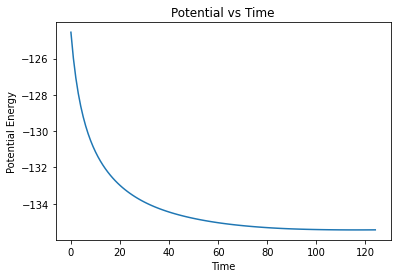

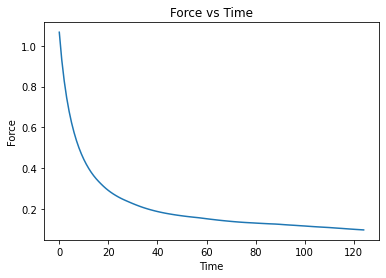

In [16]:
new_config, U_vs_Time = minimize_potential('config.xyz', sigma, epsilon, 125)

In [17]:
U_vs_Time.min()

-135.44620044925642

# Q4

In [21]:
# def energy_map(config, h):
#     energy_dist = {}
#     energy_dist[(0, 0, 0, 0)] = potential_energy(config)
#     for i in range(3 * config.shape[0]):
#         q = i // 3
#         r = i % 3
#         temp_config = copy.deepcopy(config)
#         temp_config[q][r] = temp_config[q][r] + h
#         energy_dist[(i, 1, 0, 0)] = potential_energy(temp_config)
#         temp_config[q][r] = temp_config[q][r] - 2 * h
#         energy_dist[(i, -1, 0, 0)] = potential_energy(temp_config)
#         temp_config[q][r] = temp_config[q][r] + h
#         for j in range(i):
#             q_j = j // 3
#             q_r = j % 3
#             print("Var: ", i, j)
#             temp_config[q][r] = temp_config[q][r] + h
#             temp_config[q_j][q_r] = temp_config[q_j][q_r] + h
#             energy_dist[(i, 1, j, 1)] = potential_energy(temp_config)
#             temp_config[q][r] = temp_config[q][r] - 2 * h
#             temp_config[q_j][q_r] = temp_config[q_j][q_r] - 2 * h
#             energy_dist[(i, -1, j, -1)] = potential_energy(temp_config)
#             temp_config[q][r] = temp_config[q][r] + h
#             temp_config[q_j][q_r] = temp_config[q_j][q_r] + h
            
#     return energy_dist

In [23]:
new_config = read_config('new_config.xyz')

In [24]:
def parallel(i, energy_dict, h):
    temp_config = copy.deepcopy(new_config)
    print(i)
    q = i // 3
    r = i % 3
    temp_config[q][r] = temp_config[q][r] + h
    energy_dict[(i, 1, 0, 0)] = potential_energy(temp_config)
    temp_config[q][r] = temp_config[q][r] - 2 * h
    energy_dict[(i, -1, 0, 0)] = potential_energy(temp_config)
    temp_config[q][r] = temp_config[q][r] + h
    for j in range(i):
        q_j = j // 3
        q_r = j % 3
        temp_config[q][r] = temp_config[q][r] + h
        temp_config[q_j][q_r] = temp_config[q_j][q_r] + h
        energy_dict[(i, 1, j, 1)] = potential_energy(temp_config)
        temp_config[q][r] = temp_config[q][r] - 2 * h
        temp_config[q_j][q_r] = temp_config[q_j][q_r] - 2 * h
        energy_dict[(i, -1, j, -1)] = potential_energy(temp_config)
        temp_config[q][r] = temp_config[q][r] + h
        temp_config[q_j][q_r] = temp_config[q_j][q_r] + h

In [25]:
def energy_map(config, h):
    energy = {}
    energy[(0, 0, 0, 0)] = potential_energy(config)
    temp_config = copy.deepcopy(config)        
    print("START POOLING")
    pool = Pool()
    energy_dict = Manager().dict()
    var_arr = [i for i in range(3 * config.shape[0])]
    pool.map(functools.partial(parallel, energy_dict=energy_dict, h=h), var_arr)
    pool.close()
    pool.join()
    energy.update(energy_dict)
    return energy

In [26]:
energy_dist = energy_map(new_config, 0.005)

START POOLING
0334411

22

5577


66
1
2
3
4
12
5
6
23
13
7
34
8
14
45
9
24
15
10
56
88
67
35
16
25
78
17
46
26
36
18
57
27
19
68
47
37
20
28
89
79
21
58
38
29
48
99
69
30
39
59
49
80
31
90
40
32
70
50
100
60
41
110
81
91
51
42
71
61
43
52
101
82
62
72
111
92
121
53
63
83
73
54
102
93
112
64
132
122
74
84
103
65
94
75
113
85
123
143
133
104
95
76
86
114
154
124
96
105
134
144
87
115
97
165
106
125
155
135
145
116
98
107
126
166
136
176
156
117
146
108
127
137
118
109
167
157
147
177
128
119
187
138
148
168
158
129
178
120
139
188
130
149
159
198
169
179
140
131
150
189
160
170
199
141
180
209
151
161
190
142
171
200
181
152
210
162
220
172
191
182
153
201
163
211
173
221
192
231
183
202
164
174
212
193
222
184
232
242
203
175
213
194
185
223
233
204
253
243
195
214
186
224
205
234
244
254
196
264
215
225
206
235
197
245
255
216
265
226
207
275
236
217
246
256
208
266
227
237
276
218
247
286
257
228
267
219
238
277
248
229
258
287
268
297
239
249
278
230
259
288
269
240
298
250
308
279


In [27]:
with open('energy.txt', 'w') as f:
    for k, v in energy_dist.items():
        print(f"{k} {v}", file = f)

In [37]:
def calc_Hessian(energy_dist, N, h = 0.005):
    hessian = np.zeros((3 * N, 3 * N))
    for i in range(3 * N):
        hessian[i][i] = (energy_dist[(i, 1, 0, 0)] + energy_dist[(i, -1, 0, 0)] - 2 * energy_dist[(0, 0, 0, 0)]) / (h ** 2)
        for j in range(i):
            hessian[i][j] = (energy_dist[(i, 1, j, 1)] + energy_dist[(i, -1, j, -1)] - energy_dist[(i, 1, 0, 0)] - energy_dist[(i, -1, 0, 0)] - energy_dist[(j, 1, 0, 0)] - energy_dist[(j, -1, 0, 0)] + 2 * energy_dist[(0, 0, 0, 0)]) / (2 * h ** 2)
            hessian[j][i] = hessian[i][j]
    
    with open('hessian.dat', 'w') as f:
        for i in range(3 * N):
            for j in range(3 * N):
                print(hessian[i][j], end = " ", file = f)
            print("", file = f)
        f.close()
        
    return hessian

In [38]:
hessian = calc_Hessian(energy_dist, new_config.shape[0])

In [39]:
hessian.shape

(324, 324)

# Q5

In [2]:
def read_hessian(file_name, N):
    with open(file_name) as f:
        hessian = np.zeros((3 * N, 3 * N))
        data = f.read().split("\n")
        for i in range(len(data)):
            row = data[i].split(" ")[:-1]
            for j in range(len(row)):
                hessian[i][j] = float(row[j])
    return hessian

In [3]:
hessian = read_hessian('hessian.dat', 108)

In [4]:
hessian.shape

(324, 324)

In [5]:
hessian

array([[ 1.18786498e+00,  5.11743800e-01, -1.48500874e+00, ...,
         2.51191068e-04, -5.52862502e-04,  4.55031568e-05],
       [ 5.11743800e-01,  3.32181262e+00,  5.06585949e-01, ...,
        -5.52862502e-04,  6.20924538e-04, -6.31973762e-05],
       [-1.48500874e+00,  5.06585949e-01,  2.20105790e+00, ...,
         4.55042937e-05, -6.31951025e-05, -1.41689043e-04],
       ...,
       [ 2.51191068e-04, -5.52862502e-04,  4.55042937e-05, ...,
         3.15842949e+00,  8.93543237e-01,  1.25288473e+00],
       [-5.52862502e-04,  6.20924538e-04, -6.31951025e-05, ...,
         8.93543237e-01,  2.50605998e+00,  1.26713368e+00],
       [ 4.55031568e-05, -6.31973762e-05, -1.41689043e-04, ...,
         1.25288473e+00,  1.26713368e+00,  4.38928000e+00]])

In [9]:
def make_histogram():
    eigen_value = np.linalg.eigvals(hessian)
    plt.figure(figsize=(20, 10))
    plt.title("Vibrational Frequencies")
    plt.hist(eigen_value, bins=np.arange(int(eigen_value.min())-1, int(eigen_value.max() + 1) + 1), alpha = 0.7, ec = 'black')
    plt.show()

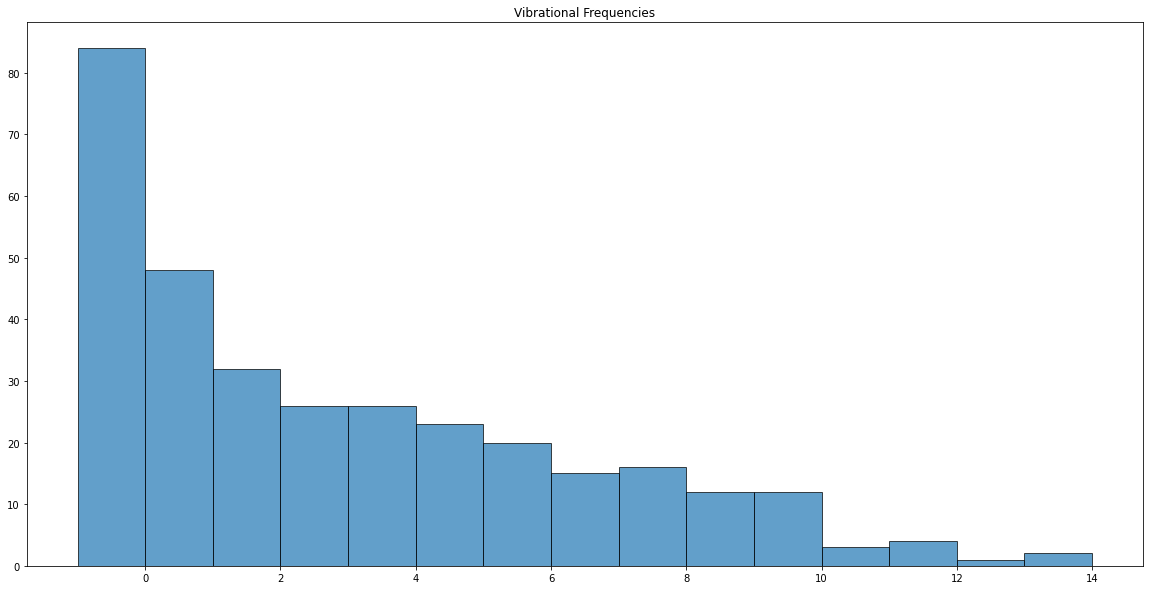

In [10]:
make_histogram()